# DNN classifier Tutorial
## Description

This tutorial is designed to:
 - Introduce the use of neural networks for binary classification
 - Introduce the Keras library
 - Teach a few basic concepts & precautions for machine learning use

This tutorial does not aim to teach a mathematical understanding of neural networks or machine learning in general, but please do ask questions.
 
The tutorial uses a high-energy physics example: separating di-Higgs production (signal) from top-pair production (the dominant background). The signal is studied in the $b\bar{b}\tau\bar{\tau}$ decay channel, and only the $\mu\tau_{h}bb$ final-state is used. Exact decay chains:
 - Signal: $gg\rightarrow hh\rightarrow b\bar{b}\tau\bar{\tau}\rightarrow 2b\,\mathrm{jets}+\mu\tau_{h}$, where $\tau_{h}$ is a hadronically decaying $\tau$ lepton (a $\tau$ jet)
 - Background: $pp\rightarrow t\bar{t}\rightarrow\ell\bar{\ell}b\bar{b}\rightarrow 2b\,\mathrm{jets}+\mu\tau_{h},\ \ell\in\{\mu,\tau\}$

The data provided is post-selection Monte Carlo simulation which uses Delphes to simulate a typical general-purpose LHC detector. The data samples were generated by teh AMVA4NewPhysics Marie Sklodowska-Curie ITN, which is funded by the Horizon2020 program of the European Commission under grant agreement: 675440.
Knowledge of the physics is assumed (but unecessary).

## Overview
The tutorial is devided into several stages:
#### Data preparation
 - Import the data
 - Add and remove features
 - Plot some features
 - Train-test splitting
 - Pre-processing
 
#### Basic classifier
 - Train a basic classifer
 - Evaluate its performance
 - Apply some regularisation
 
#### Architecture optimisation
 - Compare performance of two models
 - Cross-validation
 
#### Final evaluation
 - Understand differences between training for development and training for application
 - Introduce ensembling
 - Apply classifier to testing data

## Import

### Import modules

In [1]:
#Python 3 compatability
from __future__ import division, print_function 

#Display plots in notebook
%matplotlib inline

#Assorted
import numpy as np
import pandas
import os
import json
from six.moves import cPickle as pickle
import timeit
import types
import glob

#Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")

#SK-Learn
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Keras
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation
from keras.models import Sequential, model_from_json, load_model

#Transformations
import sys
sys.path.append('../')
from modules.Processors import *
from modules.Misc import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import data
Pandas is a very fast and flexibly way of handling data in Python. It stores data in RAM, so doesn't handle large files well... In this case less direct approaches must be used

For convenience we'll import data from CSV format, however Pandas can also import data from ROOT format via other packages, e.g.:

`MyData = pandas.DataFrame(root_numpy.root2array("MyData.root", treename = 'MyTree'))`

In [2]:
loc = "../data/"
signalData = None
backgroundData = None

signalData = pandas.read_csv(loc + "signal.csv")
backgroundData = pandas.read_csv(loc + "background.csv")
    
print("Samples contains {} signal events and {} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))

data = signalData.append(backgroundData, ignore_index = True) #Combine into single dataset
data.drop([x for x in data.columns if 'Unnamed' in x], axis=1, inplace=True)# Drop columns without header

Samples contains 71614 signal events and 103690 background events
175304 events in total


We can get an overview of the data with:

In [3]:
data.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1.0,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1.0,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1.0,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1.0,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1.0,1.0


Or:

In [4]:
[x for x in data.columns]

['t_0_pT',
 't_0_eta',
 't_0_phi',
 't_0_mass',
 't_1_pT',
 't_1_eta',
 't_1_phi',
 't_1_mass',
 'b_0_pT',
 'b_0_eta',
 'b_0_phi',
 'b_0_mass',
 'b_1_pT',
 'b_1_eta',
 'b_1_phi',
 'b_1_mass',
 'mPT_pT',
 'mPT_phi',
 'h_tt_pT',
 'h_tt_eta',
 'h_tt_phi',
 'h_tt_mass',
 'h_bb_pT',
 'h_bb_eta',
 'h_bb_phi',
 'h_bb_mass',
 'diH_pT',
 'diH_eta',
 'diH_phi',
 'diH_mass',
 'hT',
 'sT',
 'centrality',
 'eVis',
 'nJets',
 'nBJets',
 'nTauJets',
 'minJetPT',
 'meanJetPT',
 'maxJetPT',
 'minJetMass',
 'meanJetMass',
 'maxJetMass',
 'minJetEta',
 'meanJetEta',
 'maxJetEta',
 'nPhotons',
 'sphericityA',
 'spherocityA',
 'aplanarityA',
 'aplanorityA',
 'upsilonA',
 'dShapeA',
 'sphericityP',
 'spherocityP',
 'aplanarityP',
 'aplanorityP',
 'upsilonP',
 'dShapeP',
 'gen_t_0_pT',
 'gen_t_0_eta',
 'gen_t_0_phi',
 'gen_t_0_E',
 'gen_t_1_pT',
 'gen_t_1_eta',
 'gen_t_1_phi',
 'gen_t_1_E',
 'gen_b_0_pT',
 'gen_b_0_eta',
 'gen_b_0_phi',
 'gen_b_0_E',
 'gen_b_1_pT',
 'gen_b_1_eta',
 'gen_b_1_phi',
 'gen_b_1_E

Rows in the dataframe are individual events, columns are the features (variables) that are defined for each event

### Plot some features

We can plot a few of the features in one dimension:

In [5]:
def plotFeat(inData, feat, plotBulk=True, params={}):
    if plotBulk: #Ignore tails for indicative plotting
        sigRange = np.percentile(inData.loc[inData.gen_target == 1, feat], [1,99])
        bkgRange = np.percentile(inData.loc[inData.gen_target == 0, feat], [1,99])
        
        sigCut = (inData.gen_target == 1)
        sigCut = sigCut & (inData[sigCut][feat] > sigRange[0]) & (inData[sigCut][feat] < sigRange[1])
        bkgCut = (inData.gen_target == 0)
        bkgCut = bkgCut & (inData[bkgCut][feat] > bkgRange[0]) & (inData[bkgCut][feat] < bkgRange[1])
        
        sigData = inData.loc[sigCut, feat]
        bkgData = inData.loc[bkgCut, feat]
    else:
        sigData = inData.loc[inData.gen_target == 1, feat]
        bkgData = inData.loc[inData.gen_target == 0, feat]
        
    plt.figure(figsize=(16, 8))
    
    sns.distplot(bkgData, label='Background', color='b', *params)
    sns.distplot(sigData, label='Signal', color='g', *params)
    
    plt.legend(loc='best', fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.ylabel("Density", fontsize=24, color='black')
    plt.xlabel(feat, fontsize=24, color='black')
    plt.show()

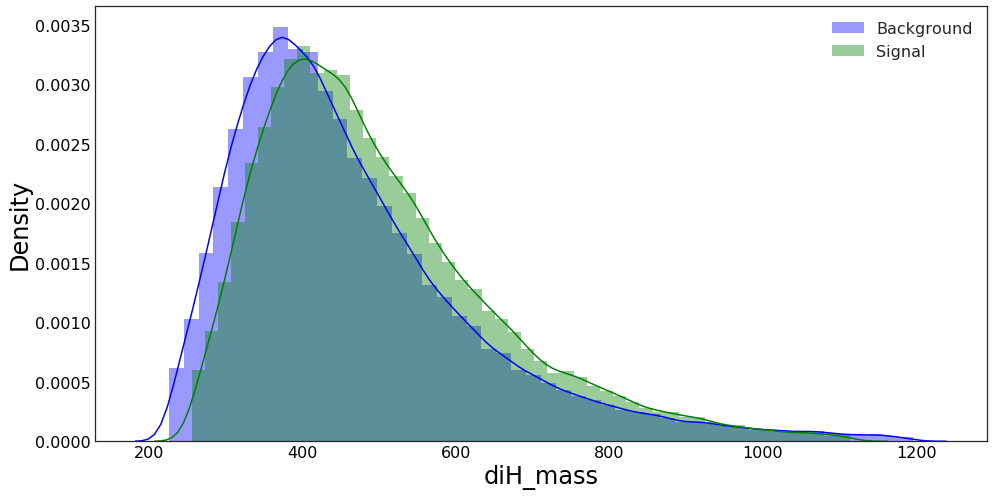

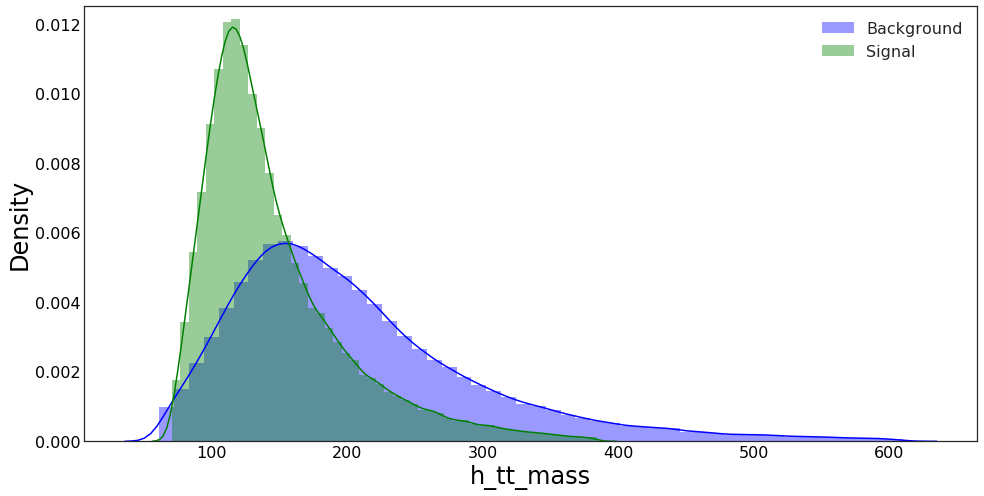

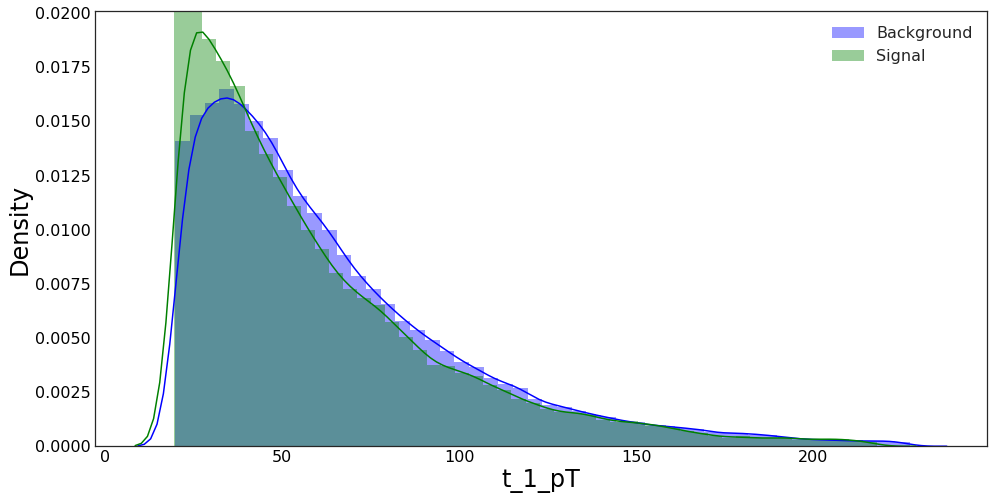

In [6]:
for feat in ['diH_mass', 'h_tt_mass', 't_1_pT']:
    #N.B. We're only plotting the percentile range 1-99, to show the bulk of the density
    plotFeat(data, feat)

## Configure data

### Process data and add new features

 - t_0 = $\tau_h$
 - t_1 = $\mu$
 - b_0 & b_1 = selected b-jets ordered by $p_T$
 - mPT = missing transverse-momenta
 - h_tt = vector-sum of t_0, t_1, and mPT ($h\rightarrow\tau\tau$)
 - h_bb = vector-sum of b_0 and b_1 ($h\rightarrow bb$)
 - diH = vector-sum of h_tt and h_bb (di-Higgs vector)

Discrimantion often works better when vectors are in Carteesian coordinates, let's transform our data and add some extra features. **N.B.** These functions are defined in `../modules/Processors.py`



In [6]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(data, p) #Calculate energy and absolute momentum
    
moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

### Create development and testing samples
Development data is used for training a model and validating its performance. Once we are happy with the model, we apply it to the testing sample to get an unbiased evaluation of the model's performance.

Note that the event selection for signal sometimes selects final-states which don't correspond to the Higgs decay products. `gen_mctMatch == 1` indicates that the correct final-sates were chosen. For a first try, we'll include the mis-selected signal events(but perhaps they could be better classified?...).

We'll use the `train_test_split` method from SK-Learn split our data. This defines lists of indices for signal and background events for the development and testing samples. About 20% of each class is reserved for validation

In [7]:
sig_devIndeces, sig_testIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_testIndeces = \
                train_test_split([i for i in data[(data.gen_target == 0)].index.tolist()],
                                 test_size=0.2, random_state=1337)

Here we split the full dataset into the dev and val sets, and define aliases for the cuts necessary to select signal and background events in each.

In [8]:
devData = data.loc[sig_devIndeces].copy()
devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)

testData = data.loc[sig_testIndeces].copy()
testData = testData.append(data.loc[bkg_testIndeces].copy(), ignore_index = True)

#Get indices of signal and background events
sigDev = (devData.gen_target == 1)
bkgDev = (devData.gen_target == 0)
sigTest = (testData.gen_target == 1)
bkgTest = (testData.gen_target == 0)

print("{} events for training, {} events for testidation".format(len(devData), len(testData)))
print("Dev: {} of which are signal and {} are background".format(len(devData[sigDev]), len(devData[bkgDev])))
print("test: {} of which are signal and {} are background".format(len(testData[sigTest]), len(testData[bkgTest])))

140243 events for training, 35061 events for testidation
Dev: 57291 of which are signal and 82952 are background
test: 14323 of which are signal and 20738 are background


## Options
Define the features used for discrimination and training options

### Feature sets

In [9]:
genFeatures = [var for var in data.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in data.columns if var not in genFeatures] #Reconstructed features; ok for training

We no longer need the old $p_T$, $\eta$, and $\phi$ coordinates so remove them from the training features. 't_1_mass' is also constant ($m_{\mu}$) so let's remove that too.

In [10]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi', 't_1_mass'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]

Not all of the available training features will actually be useful. As a first step, we can divide the features into sets and then test the impact of including/removing sets of features.

In [11]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapeFeatures = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

### Training options
Here we define the way we'll train the classifier. For simplicity we'll just use the low-level final-state features. We can also choose what pre-processing step to apply to the data.

First we'll say which sets of features we want to use:

In [12]:
classTrainFeatures = fsFeatures #The features used as inputs to the classifier
varSet = "fsFeatures" #Name of the feature set used, used for saving results
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 45 features ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


Now we'll choose what pre-processing step we want to apply. Pre-processing can help speed up training in a few ways, such as:
 - Normalisation and standardisation: Transform the data to have mean zero and standar deviation 1. The weight initialisations of networks are defined to be optimal for unit-Gaussian inputs.
 - Principal-component analysis: Rotates the data in N-dimensions such that 1-dimensional linear correlations are reduced - effectively increasing the fraction of unique information carried by each input feature. PCA can also be used to reduce the dimensionality of data by removing low-variance features, and for *whitening* the data such that all features have the same variance.
 
Pre-processing is an important step as getting the data into a suitable form can really help your training so it is worth spending time thinking about different transformations. For example, the $\phi$ symmetry of events can be worth exploiting: if the target function only depends on the angles between particles (e.g. classification, mass regression), then rotating all events to have, say the muon at $\phi=0$, can remove the need for the network to learn this symmetry. Alternatively, if the target depends on the value of $\phi$ (e.g. regression to momenta), then new training events can be generated by applying random $\phi$-rotations to the event existing events.

In [13]:
normIn = True #Whether we want to normalise and standardise the inputs
pca = True #Whether we want to use principal-component analysis to decorrelate inputs
pcaN = None #Number of dimensions to reduce data to. None = no reduction
whiten = False #White data?

Now we'll define the parameters of our model. We'll pass `classModel` later to a function which will return a pre-defined architecture.

In [14]:
classModel = "model0" #This will define the layout of the network
compileArgs = {'loss':'binary_crossentropy', #Loss function
               'optimizer':'adam'} #Optimiser for NN

Lastly, we'll define the maximum number of epochs (complete uses of training data) we want to run for, although we'll later revise this with *early stopping* (more later).
The `batch_size` sets the number of points used to evaluate the gradient before updating the weights

In [15]:
trainParams = {'epochs' : 20, #Maximum epochs for training
               'batch_size' : 64, #Size of mini-batch
               'verbose' : 0}

## Pre-process data

Here we define a SK-Learn pipeline which will contain transformation steps for any data fed in. Pipelines are a nice, compact way of handing data transformations.

In [16]:
def getPreProcPipe(normIn=False, pca=False, pcaN=False, whiten=False):
    stepsIn = []
    
    if not normIn and not pca:
        stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
        
    else:
        if pca:
            stepsIn.append(('pca', PCA(n_components=pcaN, whiten=whiten)))
            
        if normIn:
            stepsIn.append(('normPCA', StandardScaler()))
            
    return Pipeline(stepsIn)

Next we fit the pipeline to the **development** data inputs.

A compact `fit_transform` method exists, but I found sometimes it gives a different response when the fitted pipeline is applied (even to the same data), so I always fit and transform separately.

**N.B.** The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the data is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

In [17]:
inputPipe = getPreProcPipe(normIn=normIn, pca=pca, pcaN=pcaN, whiten=whiten)

inputPipe.fit(devData[classTrainFeatures].values.astype('float32')) #Fit pipeline to our inputs

X_class = inputPipe.transform(devData[classTrainFeatures].values.astype('float32')) #Transform inputs, X
y_class = devData['gen_target'].values.astype('int') #Get outputs, y

## Define classifier
Here we define the layout of the neural network. The basic class is sequential. The network is them defined by adding dense layers (which contain the neurons and weights) and then the activation function. The activation function can be defined directly in the dense constructor, however adding separately gives a clearer picture of the network, and allows it to be easily replaced with an *advanced activation-function*.

For contempory ML, the rectified linear unit (ReLU) is generally the default activation function, however new functions such as ELU, SELU, Swish, *et cetera* might give better performance.

Since we want the outputs to be between 0 (background) and 1 (signal) we'll use the sigmoid function as the final activation function, since it saturates at these values and is symmetric between them.

The compile step combines the choice of loss function and optimiser into the model.

In [18]:
def getClassifier(classModel, nIn, compileArgs):
    model = Sequential()
    
    if classModel == "model0": #Get the parameters for the predefined model
        depth = 3
        width = 100
        act = 'relu'
        init = 'he_normal'
    
    elif classModel == "model1": #Get the parameters for the predefined model
        depth = 3
        width = 100
        act = 'selu'
        init = 'VarianceScaling'
        
    model.add(Dense(width, input_dim=nIn, kernel_initializer=init)) #First layer requires number of inputs
    model.add(Activation(act)) #Add activation function
    
    for i in range(1, depth): #Continue to add hidden layers
        model.add(Dense(width, kernel_initializer=init)) #Subsequent layers inherit input_dim from previous layer
        model.add(Activation(act))
        
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')) #Final layer requires one output
    
    model.compile(**compileArgs) #Compile the network graph to prepare it for use
    return model

### Callbacks

Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

During training we'll split the development data into two parts: training and validation. The training data will be directly seen for adjusting the weights of the network. The validation data, won't be directly seen, but we'll periodically evaluate the network on it.

We want to view the history of the model's performance on the training and validation data during training, however by default the training loss is averaged over the epoch, and the validation loss is evaluated at the end of the epoch, so is not comparable. This modified version revaluates the performance on the training data at the end of each epoch.

In [19]:
class LossHistory(Callback):
    def __init__(self, trainingData):
        self.trainingData = trainingData
        
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

# First training attempt

The easist way to train the network would be to simply feed simply feed in the training data and then evaluate on the testing data. However we might want to change our model to optimise it. If we continue to test different models, and pick the one which performs best on the testing data, we can't say for certain whether the model really is the best as we don't know if it simply happened to perform best on the the given data sample.

Because we would have used the testing data to provide feedback on the model selection, it is no longer a *holdout sample* - it can't be trusted to provide an unbiased evaluation indication of performance.

It is likely that we'll want to modify our model, so let's split the development data into *training* and *validation* samples. The validation sample can then be used to optimise the architecture and once we're happy, we can finnaly use the testing sample as a genuine holdout sample.

**N.B.** This is [not always the best way to select validation data](http://www.fast.ai/2017/11/13/validation-sets/). It really depends on your use case.

Again we can use the `train_test_split` method

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_class, y_class, test_size=0.2, random_state=1337)
print('{} training events, {} validation events'.format(len(y_train), len(y_val)))

112194 training events, 28049 validation events


Now we can train the network by building the model and calling its `.fit` function.

In [21]:
%%time 

model = getClassifier(classModel, len(classTrainFeatures), compileArgs) #Get the classifier

lossHistory = LossHistory((X_train, y_train)) #Setup loss monitor

model.fit(X_train, y_train, #Training data
          validation_data = (X_val, y_val), #Validation data 
          class_weight='auto', callbacks = [lossHistory], #Balance classes, and use callback
          **trainParams) #Additional training params

CPU times: user 2min 23s, sys: 8.99 s, total: 2min 32s
Wall time: 1min 28s


Now that the model is trained we can evaluate its performance and training history:

In [22]:
def getHistoryPlot(histories):
    plt.figure(figsize=(16,8))

    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Validation')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')

    plt.legend(loc='best', fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.xlabel("Epoch", fontsize=24, color='black')
    plt.ylabel("Loss", fontsize=24, color='black')
    plt.show()

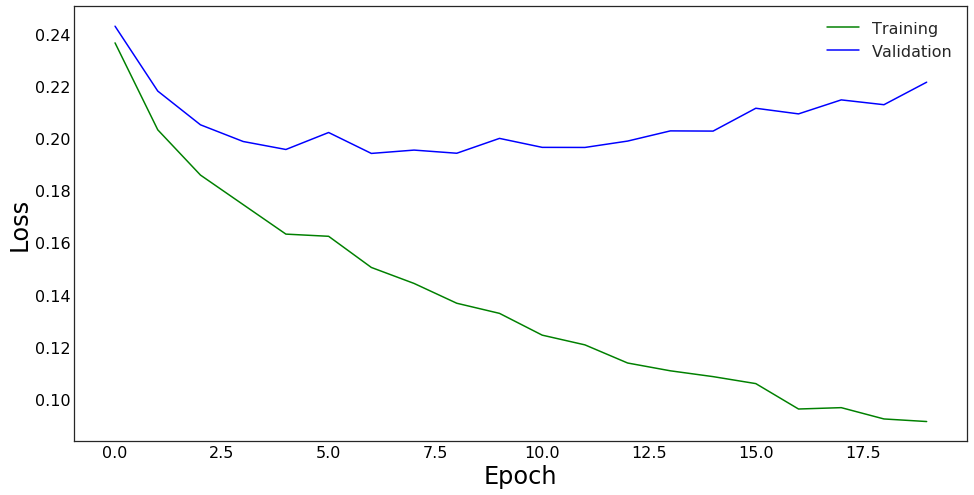

In [23]:
getHistoryPlot([lossHistory.losses])

This plot is quite interesting as it shows how the performance of the network changed over time. 

Initially the performance improved (loss decreases), however eventually the performance on the validation set eventually stops improving (aproximately between epochs 5 and 10), and actually starts getting worse! The performance on this  training set still 'shows improvement'.

This is *over-training* - we are adjusting our model too much and it begins to memorise the training data. Effectively it fits to patterns in this specific dataset which don't exist in other data samples (noise).

At this point we are trading bias to the training data for variance in its applicability, i.e. it performs well for certain data, but worse on unseen data.

Prior to the point of over-training, the model showed a plateau in validation performance, since we will be applying the model to unseen data, and want to get the best possible performance, we want to stop the training at somepoint in this plateau.

In the early stages of training the model was *under-trained* showing high-bias, but low variance - the model is unable to fully capture the real patterns that exist in the data, and so does not achieve optimal performance.

**N.B.** Occasionally one can find definitions of *over-fitting* which state that it occurs when the perfomance on train and validation samples diverge. Whilst this is *a* valid definition, in practise it is not one we are interested in. It matters when one is forced (for some reason) to re-use the training data for a purpose other than training. Really, though, one should avoid this whenever possible: once data has been used for training, it should never be fed back through the network and used for another purpose (effectively discard it).

Over/under-fitting has a more general specification to include the choice of architecture (inputs, preprocessing, hyperparameters, *et cetera*) and the method of training, not just the training itself. Its effects are partly avoided/mitigated through the use of validation samples

Now let's run the validation data through out network. We can then have a look at the distributions of the class predictions that we get. Remember that 1 = signal, 0 = background, and our predictions will be somewhere between these bounds - hopefully with signal closer to 1 and vice versa.

In [24]:
pred_val = model.predict(X_val, verbose=0)

In [25]:
def getPredDist(sig, bkg):
    plt.figure(figsize=(16, 8))
    
    params={'hist' : True, 'kde' : False, 'norm_hist' : True}
    sns.distplot(bkg, label='Background', color='b', **params)
    sns.distplot(sig, label='Signal', color='g', **params)
    
    plt.legend(loc='best', fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.xlabel("Class prediction", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
    plt.xlim([0,1])
    plt.yscale('log', nonposy='clip')
    plt.show()

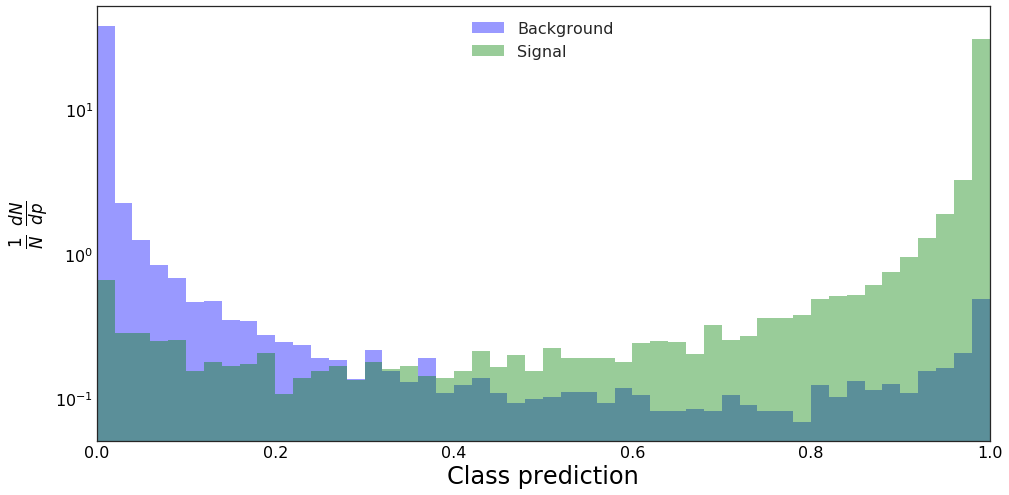

In [26]:
getPredDist(pred_val[np.nonzero(y_val)], pred_val[np.nonzero(1-y_val)])

Another useful plot for binary classification is that of the *Reciever Operating Characteristic* curve (ROC curve). If we were to place a threshold in the above plot we could label predictions to the left of the threshold as background and ones to the right as signal. Where we place this threshold, however determines how well we actually separate the two classes.

Evaluating the ROC curve means to take each data point in the above plot and ask "if the threshold were placed here, what fraction of signal and background would be to the right?". The resulting curve indicates how well we can trade off between signal acceptance and background rejection.

The area under the ROC curve (ROC AUC) can be a useful metric for comparing model performance. An AUC of 1 equates to perfect separation between signal and background. THE AUC, however, is not the only metric and is not always the best metric, so do consider [which metric is best to use](https://indico.cern.ch/event/679765/contributions/2814562/attachments/1590383/2516547/20180126-ROC-AV-IML_v008_final.pdf).

Indeed, in our case we are not directly interested in separating signal from background, but in performing a hypothesis test based on the classifier prediction. The performance is therefore tied to statistical and systematic uncertainties which the network doesn't (currently) consider. Perhaps a more meaningful metirc for comparing model performance could be the expected limit on di-Higgs production, or the (approximate) expected signal strength. However this goes a bit beyond the scope of the tutorial, so we'll stick with ROC AUC for now.

In [27]:
def rocPlot(preds, targets, labels, forceLog=None):
    log = False
    plt.figure(figsize=[8, 8])
    
    for i in range(len(preds)):
        auc = roc_auc_score(targets[i], preds[i])
        curve = roc_curve(targets[i], preds[i])[:2]
        plt.plot(*curve, label='{}, AUC = {:.5f}'.format(labels[i], auc))
        
        if auc > 0.97:
            log = True
    
    if forceLog or (log and (not isinstance(forceLog, bool) or forceLog)): #Use log x-axis
        plt.xscale('log', nonposx='clip')
    else:
        plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
        
    plt.xlabel('Background acceptance', fontsize=24, color='black')
    plt.ylabel('Signal acceptance', fontsize=24, color='black')
    plt.legend(loc='best', fontsize=16)
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.show()

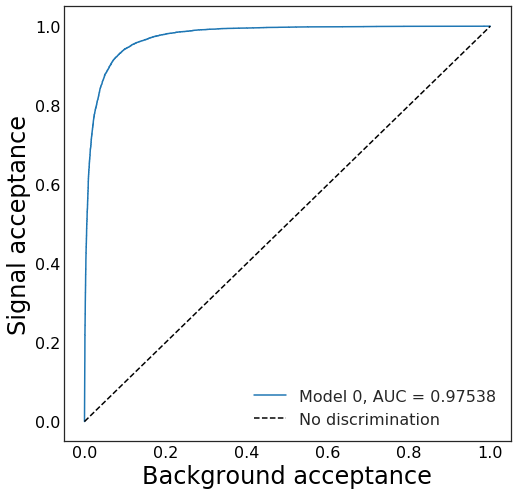

In [28]:
rocPlot([pred_val], [y_val], ['Model 0'], False)

## Additional Callbacks

As mentioned before, the current number of epochs we trained for appears to be too long, and we end up over training. We could manually set the numer to around ten, however any change in the architecture will mean we'll need to reevaluate this number. Instead, we can use additional call backs to monitor the performance and get the best classifier:

- EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the validation data and stop when it doesn't improve after 10 epochs.

- ModelCheckpoint is used to save the state of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in validation data.

The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

Since we want to rely on early stopping as our criterion to cease training, we want to set the maximum number of training epochs to something large:

In [29]:
trainParams['epochs'] = 10000

In [30]:
def trainClassifier(model, X_train, y_train, X_val, y_val, trainParams, patience=10):
    lossHistory = LossHistory((X_train, y_train)) #Setup loss monitor
    earlyStop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto') #Setup early stopping
    saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, #Save best performing network
                               save_best_only=True, save_weights_only=True, mode='auto', period=1)

    model.fit(X_train, y_train, #Training data
              validation_data = (X_val, y_val), #Validation data 
              class_weight='auto', callbacks = [lossHistory, earlyStop, saveBest], #Balance classes, and use callbacks
              **trainParams) #Additional training params
    model.load_weights("train_weights/best.h5")
    
    return model, lossHistory.losses

In [35]:
%%time 

#Create/Reset temporary storage for network states
os.system("mkdir train_weights")
os.system("rm train_weights/*.h5")

model = getClassifier(classModel, len(classTrainFeatures), compileArgs) #Get the classifier

model, history = trainClassifier(model, X_train, y_train, X_val, y_val, trainParams)

Epoch 00020: early stopping
CPU times: user 2min 28s, sys: 9.49 s, total: 2min 38s
Wall time: 1min 35s


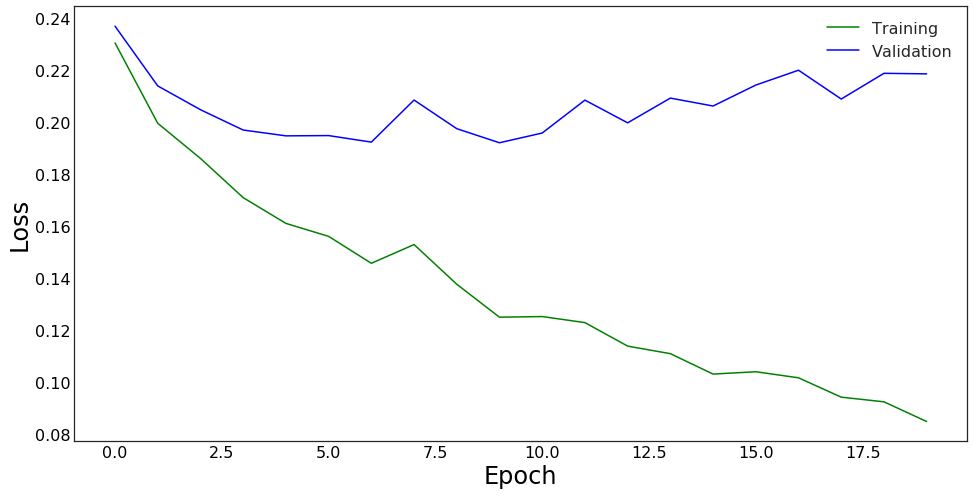

In [36]:
getHistoryPlot([history])

So, the training was about the same, however the early-stopping kicked in at epoch 17, meaning that the best performing network was found at epoch 7, and saved automatically. Let's check its performance:

In [37]:
pred_val_0 = model.predict(X_val, verbose=0)

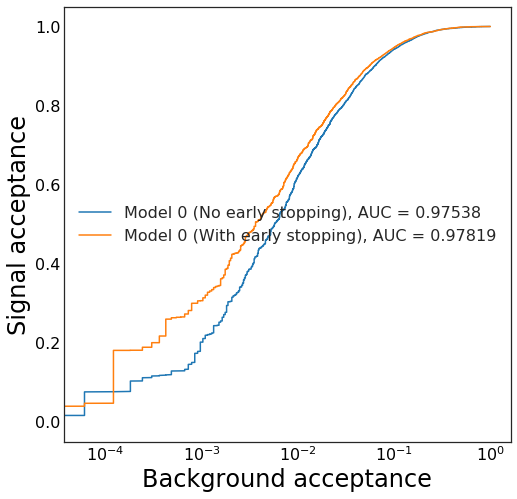

In [38]:
rocPlot([pred_val, pred_val_0],
             [y_val, y_val],
             ['Model 0 (No early stopping)', 'Model 0 (With early stopping)'])

So, a minor increase in performance, but every little helps. **N.B** we let the plot have a log axis to better highlight the difference in the curves.

# Architecture optimisation

So we just trained a model which reaches a reasonable level of performance, but can we do better?

There are several ways to adjust the model, e.g. adding new input features, transforming the data differently, or adjusting the depth, width, and other parameters of the model.

Let's stick with the exsting inputs and try changing to a different activation function. `model1` uses a self-normalising exponential linear unit (SELU), which aims to make signals remain close to unit-Gaussians as they pass though the network. Previously, this required a CPU-costly process called batch normalisation.

In [47]:
%%time 

#Creat/Reset temporary storage for network states
os.system("mkdir train_weights")
os.system("rm train_weights/*.h5")

model = getClassifier('model1', len(classTrainFeatures), compileArgs) #Get the classifier

model, history = trainClassifier(model, X_train, y_train, X_val, y_val, trainParams)

Epoch 00029: early stopping
CPU times: user 4min 40s, sys: 16 s, total: 4min 56s
Wall time: 2min 55s


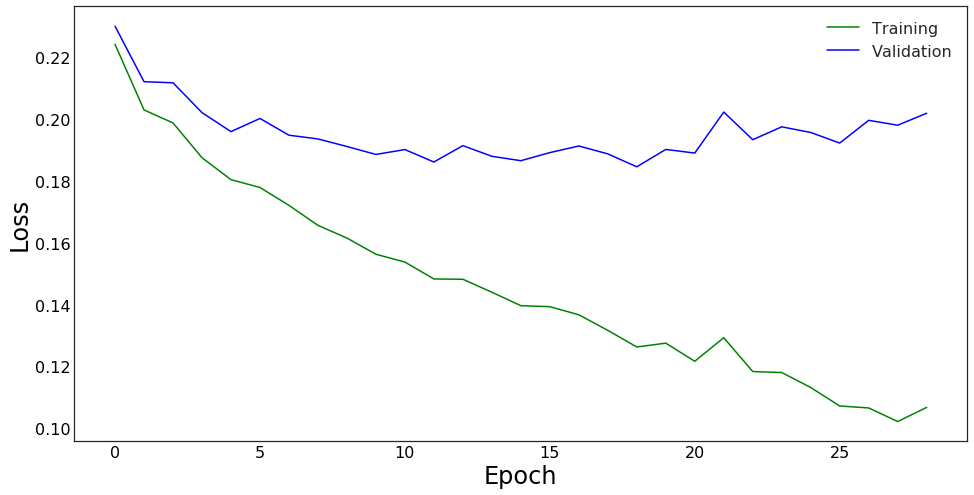

In [51]:
getHistoryPlot([history])

In [52]:
pred_val_1 = model.predict(X_val, verbose=0)

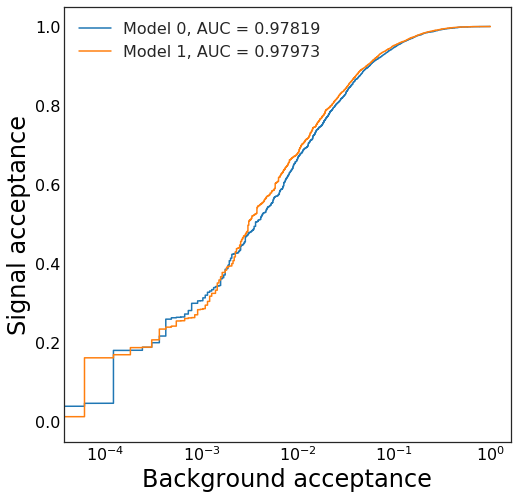

In [53]:
rocPlot([pred_val_0, pred_val_1],
             [y_val, y_val, y_val],
             ['Model 0', 'Model 1'])

So comparing our new model the old one, using SELU appears to be better; the ROC AUC is slightly higher, and the best loss is lower. However the difference in AUC is small, and the loss function over time jumps around quite a bit. Can we really be certain that SELU is providing a benefit, or could it simply be that we happened to perform better on our particular validation sample? Accepting the improvement in the later case would result in over-fitting to our validation data and might result in the end classifier not being a performant as it otherwise could have been.

We could try testing on multiple validation samples, but it could also be the case that the network converged to an unusually optimal minima and we were simply lucky to get such a good training. We really need a way to check whether the change to the architecture brings a genuine and reproduciable improvements.

# Cross-validation

We can achieve this through a process called *cross-validation*. Rather than splitting our development data into training and validation, we instead divide the dataset into *k* folds (parts). We then train a model from scratch using $k-1$ folds and evaluate the model on the remaining fold. We continue *k* times, each time using a different fold for validation.

We can then look at the mean and variance of the performnce evaluations and see whether the improvement is easily reproduced.

For classification, is can be useful to use the *stratified* version of cross-validation, which means that folds will be constructed such that each set will contain the same fraction of event classes as the full dataset, which helps ensure unbiased training.

Since where interested in the mean performance and its variance, we generally don't want to run less than five times and normally I'd run 10 folds, but for speed we'll just use 5 folds.

In [40]:
trainParams['epochs'] = 10000

In [34]:
def cvTrainClassifier(X_class, y_class, nSplits,
                      classModel, nIn, compileArgs,
                      trainParams, patience=10):
    start = timeit.default_timer()

    #Define holders for performance ledgers
    results = []
    histories = []

    #Reset temporary storage
    os.system("mkdir train_weights")
    os.system("rm train_weights/*.h5")
    os.system("rm train_weights/*.json")
    os.system("rm train_weights/*.pkl")

    #Initialise stratified k-fold splitter
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True)

    for i, (train, val) in enumerate(skf.split(X_class, y_class)): #test and train are sets of indices for the current CV fold
        fold = timeit.default_timer()
        print("Running fold", i+1, "/", nSplits)

        #Train model as normal
        model = getClassifier(classModel, nIn, compileArgs)
        model, history = trainClassifier(model, X_class[train], y_class[train], X_class[val], y_class[val],
                                         trainParams, patience=patience)
        
        #Compute and record performance and training history
        results.append({})
        results[-1]['loss'] = model.evaluate(X_class[val], y_class[val], verbose=0) #Gets loss on validation data
        results[-1]['AUC'] = roc_auc_score(y_class[val], model.predict(X_class[val], verbose=0)) #Gets ROC AUC for validation data
        histories.append(history)                               

        print("Score is:", results[-1])
        print("Fold took {:.3f}s\n".format(timeit.default_timer() - fold))

        model.save('train_weights/train_' + str(i) + '.h5') #Save the model

    #Summaries training and results
    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    getHistoryPlot(histories)
    
    meanLoss = uncertRound(np.mean([x['loss'] for x in results]), np.std([x['loss'] for x in results])/np.sqrt(len(results)))
    print("Mean loss = {} +- {}".format(meanLoss[0], meanLoss[1]))
    
    meanAUC = uncertRound(np.mean([x['AUC'] for x in results]), np.std([x['AUC'] for x in results])/np.sqrt(len(results)))
    print("Mean AUC = {} +- {}".format(meanAUC[0], meanAUC[1]))
    print("______________________________________\n")

    with open('train_weights/resultsFile.pkl', 'wb') as fout: #Save results
        pickle.dump(results, fout)
    
    return results

Running fold 1 / 5
Epoch 00016: early stopping
Score is: {'loss': 0.18646328433099701, 'AUC': 0.9778774456172395}
Fold took 68.545s

Running fold 2 / 5
Epoch 00020: early stopping
Score is: {'loss': 0.18619561462860243, 'AUC': 0.9790645358168361}
Fold took 87.098s

Running fold 3 / 5
Epoch 00020: early stopping
Score is: {'loss': 0.18457679168936938, 'AUC': 0.9791436655043642}
Fold took 86.195s

Running fold 4 / 5
Epoch 00018: early stopping
Score is: {'loss': 0.18532952050430326, 'AUC': 0.9786332656489709}
Fold took 79.784s

Running fold 5 / 5
Epoch 00017: early stopping
Score is: {'loss': 0.18901340364326052, 'AUC': 0.9780147528342367}
Fold took 76.600s


______________________________________
Training finished
Cross-validation took 398.907s 


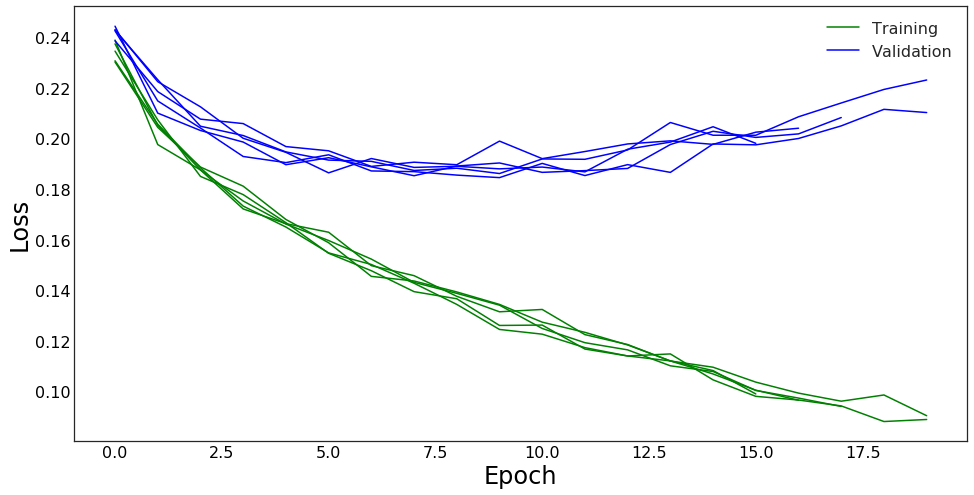

Mean loss = 0.1863 +- 0.0007
Mean AUC = 0.9785 +- 0.0002
______________________________________



In [42]:
results = cvTrainClassifier(X_class, y_class, 5, 'model0', len(classTrainFeatures), compileArgs, trainParams)

So that was for our ReLU model, now let's try SELU.

Running fold 1 / 5
Epoch 00027: early stopping
Score is: {'loss': 0.18253508158121093, 'AUC': 0.9795565970211628}
Fold took 174.386s

Running fold 2 / 5
Epoch 00024: early stopping
Score is: {'loss': 0.17683544582457053, 'AUC': 0.9805267923704741}
Fold took 144.273s

Running fold 3 / 5
Epoch 00031: early stopping
Score is: {'loss': 0.17970259555950718, 'AUC': 0.9808507570853155}
Fold took 184.211s

Running fold 4 / 5
Epoch 00026: early stopping
Score is: {'loss': 0.17616774703982177, 'AUC': 0.9809267849422757}
Fold took 152.824s

Running fold 5 / 5
Epoch 00026: early stopping
Score is: {'loss': 0.17894811874932381, 'AUC': 0.9804619481417629}
Fold took 161.963s


______________________________________
Training finished
Cross-validation took 818.556s 


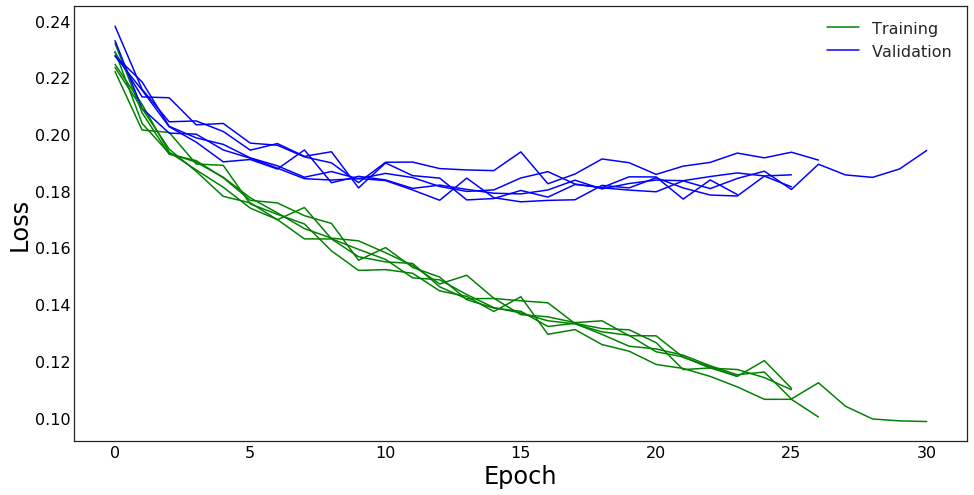

Mean loss = 0.179 +- 0.001
Mean AUC = 0.9805 +- 0.0002
______________________________________



In [35]:
results = cvTrainClassifier(X_class, y_class, 5, 'model1', len(classTrainFeatures), compileArgs, trainParams)

So comparing we the mean performances, we can be more confident that the change to our model really is bringing a genuine, reproducible improvement.

In [36]:
classModel = 'model1'

Now, let's say that we're happy with the model architecture. We now want to create a final version of the model to apply to the testing data, which so far we haven't touched. We want to make as much use of the training data as possible, and since we no longer **need** a validation sample we simply could train a fresh model on the entire of the training data.

We can, however, do something a bit different. Note how during cross-validation, the classifier performances are varied, with some networks performing slightly better than others. By just training one classifier we might end up with one that happened to be poorly trained. The simple solution is to still use CV training, and select the best performing model.

But why stop with just one? A single classifier will be slightly biased towards the data it saw during training, and won't be optimal for the whole input phase-space. Instead we can take multiple networks and combine their predictions. This is called ensembling.

# Ensembling
Note the line ` model.save('train_weights/train_' + str(i) + '.h5')` used during the earlier CV training. This saved the model we trained during that fold; we already have our ensemble trained, we just need to build it form the individual models!

The remaining question is how to combine the predictions. One way would be to treat each model equally. Another way is to weigh the better performing models more. In this way, they have the most influence over a prediction, but are supported by weaker models in cases where they might perform poorly. We can get the relative performace of each classifier from its loss on its validation fold.

Ensembling can generally be expected to provide a classifier with improved performance, effectively for free. This improvement generally increases with the number of models combined, but each addition brings decreasing gains. The evaluation time also increases.

In [57]:
class ensemble():
    def __init__(self):
        self.models = []
        self.weights = []
        self.size = 0
        self.inputPipe = None
        
    def _loadModel(self, cycle, location='train_weights/train_'): #Function to load a specified classifier
        cycle = int(cycle)
        model = load_model(location + str(cycle) + '.h5')
        return model
    
    def _getWeights(self, value, mode='rec'): #How the weight is calculated.
        if mode == 'rec':
            return 1/value #Reciprocal of metric is a simple way of assigning larger weights to better metrics
        elif mode == 'uni':
            return 1 #Uniform weighting
        else:
            print("Weight mode not recognised/supported")
            return 0

    def buildEnsemble(self, results, size, weighting='rec', verbose=True):
        self.models = []
        weights = []

        dtype = [('cycle', int), ('result', float)]
        values = np.sort(np.array([(i, result['loss']) for i, result in enumerate(results)], 
                                  dtype=dtype), order=['result'])

        for i in range(min([size, len(results)])):
            self.models.append(self._loadModel(values[i]['cycle']))
            weights.append(self._getWeights(values[i]['result'], mode=weighting))
            if verbose: print("Model {} is {} with loss = {}". format(i, values[i]['cycle'], values[i]['result']))

        weights = np.array(weights)
        self.weights = weights/weights.sum() #normalise weights
        self.size = len(self.models)
    
    def addInputPipe(self, pipe):
        self.inputPipe = pipe

    def predict(self, X, n=-1): #Loop though each classifier and predict data class
        if not isinstance(self.inputPipe, types.NoneType): #Preprocess if necessary
            X = self.inputPipe.transform(X)
        
        pred = np.zeros((len(X), 1))
        
        if n == -1:
            n = len(self.models)+1
            
        models = self.models[0:n] #Use only specified number of classifiers
        weights = self.weights[0:n]/self.weights[0:n].sum() #Renormalise weights

        for i, model in enumerate(models): #Weight each model prediction
            pred += weights[i]*model.predict(X, verbose=0)
        
        return pred
    
    def save(self, filename, overwrite=False):
        if (len(glob.glob(filename + "*.json")) or len(glob.glob(filename + "*.h5")) or len(glob.glob(filename + "*.pkl"))) and not overwrite:
            print("Ensemble already exists with that name, call with overwrite=True to force save")
        
        else:
            os.system("rm " + filename + "*.json")
            os.system("rm " + filename + "*.h5")
            os.system("rm " + filename + "*.pkl")
            
            for i, model in enumerate(self.models):
                model.save(filename + '_' + str(i) + '.h5')
                
            with open(filename + '_weights.pkl', 'w') as fout:
                pickle.dump(self.weights, fout)
                
            if not isinstance(self.inputPipe, types.NoneType):
                with open(filename + '_inputPipe.pkl', 'w') as fout:
                    pickle.dump(inputPipe, fout)
                    
    def load(self, filename):
                
        self.models = []
        
        for model in glob.glob(filename + '_*.h5'):
            self.models.append(load_model(model))
        
        with open(filename + '_weights.pkl', 'r') as fin:
            self.weights = weights = pickle.load(fin)
            
        try:
            with open(filename + '_inputPipe.pkl', 'r') as fin:
                self.inputPipe = pickle.load(fin)
        except IOError:
            self.inputPipe = None

In [58]:
with open('train_weights/resultsFile.pkl', 'r') as fin:
    results = pickle.load(fin)

In [68]:
classifier = ensemble()
classifier.buildEnsemble(results, 5)
classifier.addInputPipe(inputPipe)

Model 0 is 3 with loss = 0.17616774704
Model 1 is 1 with loss = 0.176835445825
Model 2 is 4 with loss = 0.178948118749
Model 3 is 2 with loss = 0.17970259556
Model 4 is 0 with loss = 0.182535081581


## Ensemble testing
What benefit does ensembling bring? Let's take a look!

In [69]:
X_dev = devData[classTrainFeatures].values.astype('float32')
y_dev = devData['gen_target'].values.astype('int')

In [70]:
for i in range(classifier.size):
    time = timeit.default_timer()
    auc = roc_auc_score(y_dev, classifier.predict(X_dev, n=i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f},\teval time: {} s/event".format(auc, (timeit.default_timer()-time)/len(y_dev)))
    else:
        print("AUC using {} classifiers:\t{:.5f},\teval time: {} s/event".format(i+1, auc, (timeit.default_timer()-time)/len(y_dev)))

AUC using best classifier:	0.98673,	eval time: 3.8594853049e-05 s/event
AUC using 2 classifiers:	0.98822,	eval time: 4.91285756247e-05 s/event
AUC using 3 classifiers:	0.98902,	eval time: 8.23541136813e-05 s/event
AUC using 4 classifiers:	0.99006,	eval time: 9.30052477552e-05 s/event
AUC using 5 classifiers:	0.99045,	eval time: 0.000128192365691 s/event


Definite improvements seen, but we also see the effect of decreasing returns.

## Response on testing data
Having done all the development of the classifier, we're now ready to do final testing on the withheld testing data.

In [71]:
pred = classifier.predict(testData[classTrainFeatures].values.astype('float32'))
testData['pred_class'] = pandas.Series(pred[:,0], index=testData.index) #Add predicted class to test data

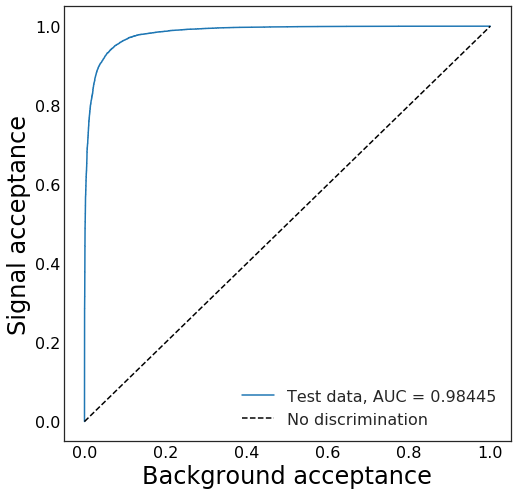

In [72]:
rocPlot([testData['pred_class']], [testData['gen_target']], ['Test data'], forceLog=False)

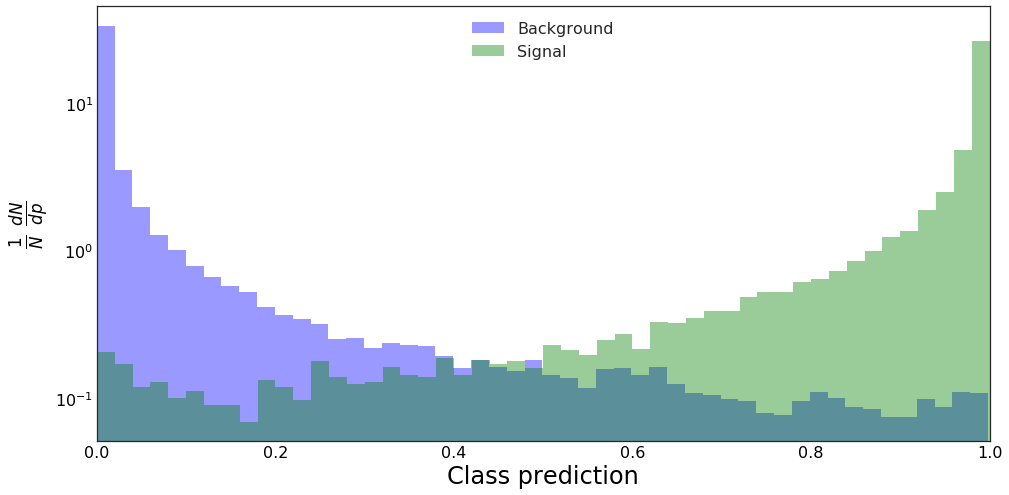

In [73]:
getPredDist(testData[sigTest]['pred_class'], testData[bkgTest]['pred_class'])

## Save/load
We can save the classifier and load it later

In [53]:
!mkdir "weights"

mkdir: cannot create directory ‘weights’: File exists


In [60]:
name = "weights/NN_{}_{}".format(varSet, classModel)
print("Saving to", name)

Saving to weights/NN_fsFeatures_model1


In [61]:
classifier.save(name,1)

Reload with:
```
loadedClassifier = classifier()
loadedClassifier.load(name)
```